In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import argparse 
import glob 

/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Analyze Coco Dataset

In [28]:
train_pkl = pickle.load(open("../../../datasets/coco/preprocessed/val.pkl","rb"))

In [30]:
concepts = pickle.load(open("../../../datasets/coco/preprocessed/concepts.pkl","rb"))
concept_names = json.load(open("../../../datasets/coco/preprocessed/instances_train2014.json"))['categories']
concept_names_from_id = {}

for i in concept_names:
    concept_names_from_id[i['id']] = i['name']
relevant_concepts = [concept_names_from_id[i] for i in concepts]

['fork', 'bed']

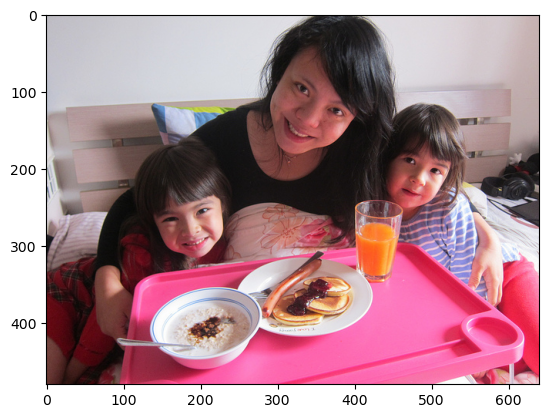

In [31]:
idx = 1
image = train_pkl[idx]['img_path']
plt.imshow(Image.open(open("../../../datasets/{}".format(image),"rb")))
[relevant_concepts[i] for i,val in enumerate(train_pkl[idx]['attribute_label']) if val == 1]

In [38]:
print(relevant_concepts)

['bird', 'backpack', 'kite', 'wine glass', 'fork', 'broccoli', 'donut', 'bed', 'remote', 'keyboard']


In [32]:
freq_by_concept = np.zeros(len(concepts))

for i in train_pkl:
    freq_by_concept += np.array(i['attribute_label'])
freq_by_concept/len(train_pkl)

array([0.04469274, 0.1452514 , 0.12569832, 0.31005587, 0.62569832,
       0.39385475, 0.10893855, 0.06145251, 0.11452514, 0.11731844])

In [33]:
smallest_indices = np.argsort(freq_by_concept)[:7]


In [39]:
sorted([relevant_concepts[i] for i in smallest_indices])

['backpack', 'bed', 'bird', 'donut', 'keyboard', 'kite', 'remote']

In [34]:
for i in train_pkl:
    attribute_labels = i['attribute_label']
    class_label = int(np.sum(np.array(attribute_labels)[smallest_indices])>0)
    assert class_label == i['class_label']

AssertionError: 

In [36]:
np.sum([i['class_label'] for i in train_pkl])/len(train_pkl)

0.7849162011173184

In [35]:
np.mean([max(i,1-i) for i in freq_by_concept/len(train_pkl)])

0.8203910614525141

## Add Gaussian Noise

In [13]:
all_images = glob.glob("../../../datasets/"+dataset_orig+"/images/*.png")


In [18]:
for num_objects in [1,2,4,8]:
    dataset_orig = "synthetic_object/synthetic_{}".format(num_objects)
    dataset_new = "synthetic_object/synthetic_{}_noisy".format(num_objects)
    all_images = glob.glob("../../../datasets/"+dataset_orig+"/images/*.png")
    all_images = [i.split("/")[-1] for i in all_images]
    
    for img_name in all_images:
        img_orig = Image.open("../../../datasets/"+dataset_orig + "/images/"+img_name)
        img_final = add_gaussian_noise(img_orig)
        img_final.save("../../../datasets/"+dataset_new+ "/images/"+img_name)

In [27]:
for num_objects in [1,2,4,8]:
    for fold in ["train","val","test"]:
        dataset_orig = "synthetic_object/synthetic_{}".format(num_objects)
        dataset_new = "synthetic_object/synthetic_{}_noisy".format(num_objects)
        pkl_location = "../../../datasets/"+dataset_new+"/preprocessed/{}.pkl".format(fold)
        pickle_file = pickle.load(open(pkl_location,"rb"))
        for i in pickle_file:
            i['img_path'] = i['img_path'].replace(dataset_orig,dataset_new)
        pickle.dump(pickle_file,open(pkl_location,"wb"))

## Set up dataset + model

In [7]:
# parser = argparse.ArgumentParser(description="Your script description here")

# # Add command-line arguments
# parser.add_argument('--num_objects', type=int, default=2, help='Number of objects')
# parser.add_argument('--noisy', action='store_true', help='Enable noisy')
# parser.add_argument('--weight_decay', type=float, default=0.0004, help='Weight decay value')
# parser.add_argument('--encoder_model', type=str, default='inceptionv3', help='Encoder model')
# parser.add_argument('--optimizer', type=str, default='sgd', help='Optimizer')
# parser.add_argument('--seed', type=int, default=42, help='Random seed')

# # Parse the command-line arguments
# args = parser.parse_args()

# # Now you can access the variables using args.num_objects, args.noisy, etc.
# num_objects = args.num_objects
# noisy = args.noisy
# weight_decay = args.weight_decay
# encoder_model = args.encoder_model
# optimizer = args.optimizer
# seed = args.seed

num_objects = 1
noisy=False
weight_decay = 0.0004
encoder_model='small7'
optimizer = 'sgd'
seed = 42

results_folder = "results/synthetic/objects={}_noisy={}_wd={}_model={}_optimizer={}_seed={}".format(
    num_objects,noisy,weight_decay,encoder_model,optimizer,seed
)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [8]:
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
# TODO: Undo this later so it's synthetic 

train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy)
# train_loader, val_loader, train_pkl, val_pkl = get_data_by_name("CUB")
val_images, val_y, val_c = unroll_data(val_loader)

In [10]:
# TODO: Undo this later so it's synthetic
joint_model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

## Test out new Mask Model

In [45]:
from ConceptBottleneck.CUB.template_model import MLPWithMask, MLP, SimpleConvNet, End2EndModel
model = MLPWithMask(299*299*3,2)

In [46]:
model

MLPWithMask(
  (activation): ReLU()
  (linear): Linear(in_features=196608, out_features=15, bias=True)
  (linear2): Linear(in_features=15, out_features=2, bias=True)
)

In [48]:
x, _, _ = model.forward(torch.stack([val_images[0],val_images[1]]))

In [49]:
x

[tensor([[0.1825],
         [0.2527]], grad_fn=<ReshapeAliasBackward0>),
 tensor([[-0.1286],
         [-0.0921]], grad_fn=<ReshapeAliasBackward0>)]

In [17]:
model2 = MLP(input_dim=2, num_classes=2,expand_dim=1)

In [21]:
End2EndModel(model,model2).forward(torch.stack([val_images[0],val_images[1]]))

Mask size torch.Size([2, 1, 256, 256])
X Shape torch.Size([2, 3, 256, 256])
Mask size torch.Size([2, 1, 256, 256])
X Shape torch.Size([2, 3, 256, 256])


([tensor([[0.2783, 0.3591],
          [0.2783, 0.3591]], grad_fn=<AddmmBackward0>),
  tensor([[0.0008],
          [0.0009]], grad_fn=<AddmmBackward0>),
  tensor([[0.0014],
          [0.0010]], grad_fn=<AddmmBackward0>)],
 [tensor([[0.2783, 0.3591],
          [0.2783, 0.3591]], grad_fn=<AddmmBackward0>),
  tensor([[0.0008],
          [0.0009]], grad_fn=<AddmmBackward0>),
  tensor([[0.0014],
          [0.0010]], grad_fn=<AddmmBackward0>)])

In [22]:
model_simple = SimpleConvNet(num_classes=2, aux_logits=True,
                              n_attributes=2, bottleneck=True, expand_dim=0,
                              three_class=(1 == 3))

In [27]:
model.forward(torch.stack([val_images[0],val_images[1]]))

Mask size torch.Size([2, 1, 256, 256])
X Shape torch.Size([2, 3, 256, 256])
Mask size torch.Size([2, 1, 256, 256])
X Shape torch.Size([2, 3, 256, 256])


([tensor([[0.0008],
          [0.0009]], grad_fn=<AddmmBackward0>),
  tensor([[0.0014],
          [0.0010]], grad_fn=<AddmmBackward0>)],
 [tensor([[0.0008],
          [0.0009]], grad_fn=<AddmmBackward0>),
  tensor([[0.0014],
          [0.0010]], grad_fn=<AddmmBackward0>)])

In [24]:
model_simple.forward(torch.stack([val_images[0],val_images[1]]))

([tensor([[0.0142],
          [0.0046]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.0024],
          [-0.0038]], grad_fn=<AddmmBackward0>)],
 [tensor([[0.0142],
          [0.0046]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.0024],
          [-0.0038]], grad_fn=<AddmmBackward0>)])

In [23]:
End2EndModel(model_simple,model2).forward(torch.stack([val_images[0],val_images[1]]))

([tensor([[0.2783, 0.3591],
          [0.2783, 0.3591]], grad_fn=<AddmmBackward0>),
  tensor([[0.0142],
          [0.0046]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.0024],
          [-0.0038]], grad_fn=<AddmmBackward0>)],
 [tensor([[0.2783, 0.3591],
          [0.2783, 0.3591]], grad_fn=<AddmmBackward0>),
  tensor([[0.0142],
          [0.0046]], grad_fn=<AddmmBackward0>),
  tensor([[ 0.0024],
          [-0.0038]], grad_fn=<AddmmBackward0>)])

In [ ]:
criterion = nn.L1Loss()  # L1 loss
loss = criterion(mask, target)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  

In [ ]:
optimizer.zero_grad()

In [ ]:
loss.backward()

## Plot the Dataset

In [13]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image.save("{}/{}.png".format(results_folder,i+1))

## Analyze Accuracy

In [ ]:
train_acc, val_acc = get_accuracy(joint_model,run_joint_model,train_loader).item(), get_accuracy(joint_model,run_joint_model,val_loader).item()

In [ ]:
accuracy_by_concept_train = get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True).detach().numpy()

## Analyze Concept-Task Relationships

In [ ]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

## Prune Model

In [166]:
joint_model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

In [167]:
# pruning_rate = 0.95
# for layer in joint_model.first_model.children():
#     if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
#         torch.nn.utils.prune.l1_unstructured(layer, name="weight", amount=pruning_rate)


In [168]:
pruning_rate = 0.95
for layer_to_prune in [joint_model.first_model.conv4, 
                       joint_model.first_model.conv5,
                       joint_model.first_model.conv6,
                       joint_model.first_model.conv7]:

    weight = layer_to_prune.weight.data.abs().clone()
    importance = weight.sum((1, 2, 3))  # Calculate importance of filters
    num_filters = layer_to_prune.weight.size(0)

    # Compute the number of filters to prune
    num_prune = int(num_filters * pruning_rate)
    _, indices = importance.sort(descending=True)
    indices_to_prune = indices[-num_prune:]

    # Create a mask to prune filters
    mask = torch.ones(num_filters)
    mask[indices_to_prune] = 0
    if mask is not None:
        mask = mask.to(layer_to_prune.weight.device)
        layer_to_prune.weight.data *= mask.view(-1, 1, 1, 1)


In [169]:
pruned_weights = []
for module in joint_model.first_model.children():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
        pruned_weights.append(torch.sum(module.weight == 0).item() / module.weight.nelement())

print("Pruning percentages for each layer:", pruned_weights)

Pruning percentages for each layer: [0.0, 0.0, 0.0, 0.94921875, 0.94921875, 0.94921875, 0.94921875]


## Analyze Concept-Input Relationships

### Counterfactual Images

#### Blank, Filled, and Half Images

In [82]:
no_color = torch.Tensor([0.25,0.25,0.25])
full_color = torch.Tensor([-0.25,-0.25,0.25])

In [83]:
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
full_image = full_color.clone().view(3, 1, 1).expand_as(blank_image)

half_left = no_color.view(3, 1, 1).expand_as(blank_image).clone()
half_left[:,:,:128] = full_image[:,:,:128]

half_right = no_color.clone().view(3, 1, 1).expand_as(blank_image).clone()
half_right[:,:,128:] = full_image[:,:,128:]

In [84]:
all_images = [blank_image,full_image,half_left,half_right]
all_images = torch.stack(all_images)
str_names = ["Blank","Full","Half-Left","Half-Right"]

In [85]:
y,c = run_joint_model(joint_model,all_images)
c = c.T
c = torch.nn.Sigmoid()(c).detach().numpy()
c = np.round(c,3)

### Maximal Activation

In [86]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

In [170]:
activation_values = []

for concept_num in range(num_objects*2):
    ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                       get_valid_image_function(concept_num,num_objects,epsilon=32))
    activation_values.append (
        torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[concept_num][0].detach().numpy()
    )

In [171]:
activation_values 

[array(1., dtype=float32), array(0.16009563, dtype=float32)]

In [172]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True).detach().numpy()

array([0.48046875, 0.48046875], dtype=float32)

## CUB Dataset Exploration

In [7]:
dataset_name = "CUB"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [8]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))

In [9]:
part_file = open("../cem/cem/CUB/metadata/parts/part_locs.txt").read().strip().split("\n")

In [11]:
part_list = open("../cem/cem/CUB/metadata/parts/parts.txt").read().strip().split("\n")
part_list = [' '.join(i.split(' ')[1:]) for i in part_list]

In [12]:
attribute_names = open("../cem/cem/CUB/metadata/attributes.txt").read().strip().split("\n")
attribute_names = [' '.join(i.split(' ')[1:]) for i in attribute_names]

In [22]:
parts_to_attribute = {}

for i in range(len(part_list)):
    current_name = str(i)
    
    parts_to_attribute[current_name] = [] 
    parts_split = part_list[i].split(' ')

    for j in range(len(attribute_names)):
        main_part = set(attribute_names[j].split("::")[0].split("_"))

        if len(main_part.intersection(parts_split)) > 0:
            parts_to_attribute[current_name].append(j)

In [24]:
invisibility_by_id = {}
invisible_parts = {}
for i in part_file:
    split_vals = i.split(' ')

    if split_vals[-1] == '0':
        image_id = int(split_vals[0])
        part_id = int(split_vals[1])-1 # 0 index 
        x = float(split_vals[2])
        y = float(split_vals[3])

        if image_id not in invisibility_by_id:
            invisibility_by_id[image_id] = set()
            invisibility_parts[image_id] = set() 
        invisibility_by_id[image_id] = invisibility_by_id[image_id].union(set(parts_to_attribute[str(part_id)]))

In [15]:
data_point = 0

In [33]:
_id = val_pkl[data_point]['id']
invisible_vals = list(invisibility_by_id[_id])
true_vals = np.array(val_pkl[data_point]['attribute_label'])[invisible_vals]
clashing_attributes = [attribute_names[invisible_vals[i]] for i in range(len(true_vals)) if true_vals[i] == 1]
clashing_attributes

['has_wing_color::white', 'has_wing_pattern::solid', 'has_eye_color::black']

In [36]:
_id, invisibility_by_id[_id]

(3640, {4, 5, 6, 7, 8, 9, 50, 76, 77, 108, 109, 110, 111})

## dSprites Dataset

In [8]:
attribute_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

In [10]:
dataset_name = "dsprites"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
train_data_path = os.path.join(data_dir, 'train.pkl')
train_pkl = pickle.load(open(train_data_path,"rb"))

In [21]:
len(train_pkl[0]['attribute_label'])

18

In [16]:
paired = []

for i in range(len(attribute_names)):
    for j in range(i):
        if True:
            for k in train_pkl:
                if k['attribute_label'][i] != k['attribute_label'][j]:
                    break 
            else:
                paired.append((attribute_names[i],attribute_names[j]))
paired

[]

In [23]:
npz_file = np.load(open("../cem/cem/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz","rb"))

In [24]:
def generate_combinations(choices):
    num_choices = len(choices)
    combinations = []

    for i in range(num_choices):
        current_combinations = []

        for j in range(choices[i]):
            current_combinations.append(j)
        
        combinations.append(current_combinations)
    
    from itertools import product
    result = list(product(*combinations))
    
    return result


In [25]:
choices_by_value = [1,3,6,4,2,2]

In [27]:
def image_has_orientation(orient,concepts):
    """Check if an image concept matches the orientation in orient
    
    Arguments: 
        orient: Array representing an orientation
        concepts: An image concepts which matches up with the orientation

    Returns: Boolean True or False"""
    max_range_by_value = [-1,-1,-1,40,32,32]
    choices_by_value = [1,3,6,4,2,2]


    for i in range(len(orient)):
        if max_range_by_value[i] == -1:
            if orient[i] != concepts[i]:
                return False
        else:
            equiv_orient = concepts[i]/max_range_by_value[i]*choices_by_value[i]
            equiv_orient = int(equiv_orient)

            if equiv_orient != orient[i]:
                return False
                
    return True

def get_matching_images(orientation,npz_file):
    """Get the indices of all matching images for a particular orientation
    
    Arguments:
        orientation: List of 6 numbers representing an orientation
        npz_file: Handle for the NPZ file for DSprites
        
    Returns: List of indices for valid images"""
    
    latents = npz_file['latents_classes']
    return [i for i in range(len(latents)) if image_has_orientation(orientation,latents[i])]
    
def write_image(idx,imgs):
    """Write an image, indexed by idx, to the dsprites folder
    
    Arguments:
        idx: Number index into npz_File
        npz_file: Handle for the NPZ file for DSprites
    
    Returns: Nothing
    
    Side Effects: Writes an image to dataset/dsprites/images/idx.png
    """
    
    bw_arr = imgs[idx]
    rgb_arr = np.repeat(np.expand_dims(bw_arr, axis=2), 3, axis=2) * 255
    img = Image.fromarray(rgb_arr.astype('uint8'), 'RGB')
    img.save('../cem/cem/dsprites/images/extra_{}.png'.format(idx))


In [28]:
def one_hot_orientation(orientation):
    """Given some orientation, one hot encode it
    
    Arguments: 
        Orientation: List of size 6
    
    Returns: List of size 1+3+6+3+2+2 = 18"""
    
    one_hot = []
    max_range_by_value = [-1,-1,-1,40,32,32]
    choices_by_value = [1,3,6,4,2,2]
    
    for i in range(len(orientation)):
        for j in range(choices_by_value[i]):
            if orientation[i] == j:
                one_hot.append(1)
            else:
                one_hot.append(0)
    
    return one_hot

In [29]:
def binary_to_decimal(binary_list):
    """Convert a list of 0s and 1s to a binary number
    
    Arguments: 
        binary_list: List of 0s and 1s
    
    Returns: Equivalent integer"""
    
    binary_str = ''.join(map(str, binary_list))
    decimal_num = int(binary_str, 2)
    return decimal_num

In [30]:
def write_dataset(orientations,npz_file, write_images=False):
    """Write the metadata train.pkl, etc. based on orientations array
    
    Arguments:
        orientations: List of orientations, which is a list of numbers
        npz_file: Handle for the NPZ file for Dsprites
    
    Returns: Nothing
    
    Side Effects: Writes files and metadata pkl
        
    """
    
    imgs = npz_file['imgs']
    images_by_orientation = [get_matching_images(o,npz_file) for o in orientations]
    
    for i in range(len(images_by_orientation)):
        random.shuffle(images_by_orientation[i])
        
    num_train = [0,1]
    
    num_split = {
        'extra': num_train,
    }
    
    
    for split in ["extra"]:
        pkl_file_info = []
        pkl_file_loc = "../cem/cem/dsprites/preprocessed/{}.pkl".format(split)
        
        low, high = num_split[split]
        
        for o, orientation in enumerate(orientations):
            one_hot = one_hot_orientation(orientation)
            for idx in images_by_orientation[o][low:high]:
                d = {
                    'id': idx,
                    'img_path': 'dsprites/images/extra_{}.png'.format(idx),
                    'class_label': binary_to_decimal(one_hot)%100,
                    'attribute_label': one_hot,
                }
                pkl_file_info.append(d)
                
                if write_images:
                    write_image(idx,imgs)
        
        w = open(pkl_file_loc,"wb")
        pickle.dump(pkl_file_info,w)
        w.close()

In [31]:
orientations = generate_combinations(choices_by_value)
len(orientations)

288

In [32]:
write_dataset(orientations,npz_file, write_images=True)

### Saliency Maps

In [18]:
x = val_images 
model_function = run_joint_model 
model = joint_model 
concept_num, input_num = 1, 0

In [19]:
val_images.requires_grad = True

y,c = run_joint_model(joint_model,val_images)

grads = torch.autograd.grad(c[0], val_images, grad_outputs=torch.ones_like(c[concept_num]), retain_graph=True)
grads = grads[0]
saliency_map = F.relu(grads).max(dim=1, keepdim=True)[0]

In [20]:
new_saliency = saliency_map/saliency_map.abs().max()
new_saliency = new_saliency.detach().cpu().numpy()

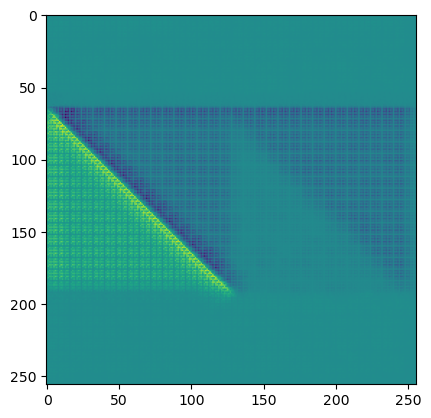

In [22]:
plt.imshow(grads[0,0])

In [32]:
a = grads[0,0].detach().numpy()

In [34]:
normalized = (a-np.min(a))/(np.max(a)-np.min(a))

In [46]:
val_images.requires_grad = True

y,c = run_joint_model(joint_model_large,val_images)

grads_large = torch.autograd.grad(c[0], val_images, grad_outputs=torch.ones_like(c[concept_num]), retain_graph=True)
grads_large = grads_large[0]

In [48]:
grads_large = grads_large.detach().numpy()

In [49]:
normalized_large = (grads_large-np.min(grads_large))/(np.max(grads_large)-np.min(grads_large))

In [53]:
normalized_large = normalized_large[0,0]

In [78]:
np.max(normalized_large - (normalized))

0.43509766

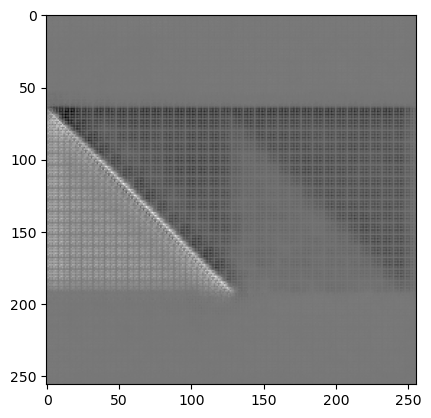

In [81]:
plt.imshow(normalized_large - (normalized), cmap='binary')

In [59]:
normalized_large[71,13]/normalized[71,13]

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in float_scalars
  """Entry point for launching an IPython kernel.


inf

In [62]:
ratio = normalized_large/(normalized+0.0001)
ratio = (ratio-np.min(ratio))/(np.max(ratio)-np.min(ratio))

In [63]:
ratio

array([[0.00021189, 0.00021167, 0.00020966, ..., 0.0002128 , 0.00021249,
        0.00021204],
       [0.00021158, 0.00021144, 0.00020947, ..., 0.00021295, 0.00021283,
        0.00021259],
       [0.00021016, 0.00020704, 0.00020957, ..., 0.00021169, 0.00021395,
        0.00021235],
       ...,
       [0.00021194, 0.00021152, 0.00021087, ..., 0.00021215, 0.00021144,
        0.00021157],
       [0.00021251, 0.00021157, 0.00021175, ..., 0.00021217, 0.00021141,
        0.00021172],
       [0.00021206, 0.00021055, 0.00021019, ..., 0.0002107 , 0.00021204,
        0.00021109]], dtype=float32)

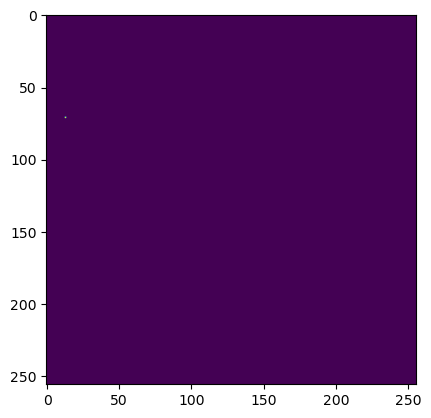

In [64]:
plt.imshow(ratio)

In [37]:
input_normalized = x[0,0].detach().numpy()
input_normalized = (input_normalized-np.min(input_normalized))/(np.max(input_normalized)-np.min(input_normalized))

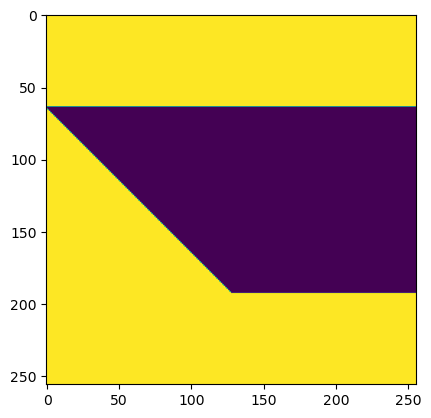

In [38]:
plt.imshow(input_normalized)

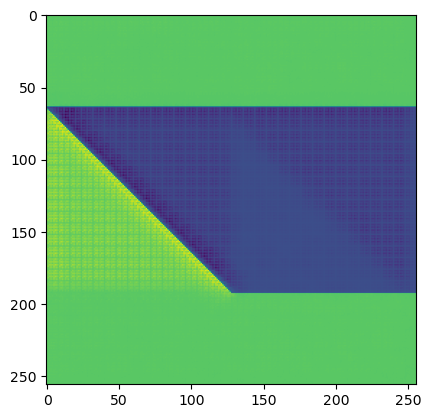

In [44]:
plt.imshow(normalized - (1-input_normalized))

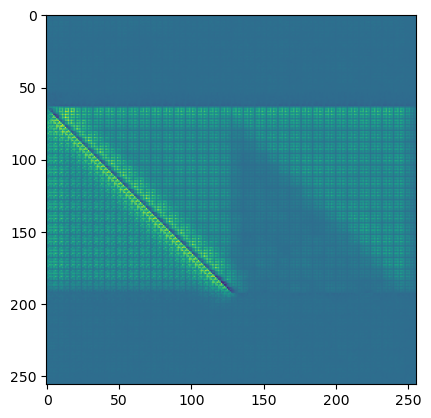

In [26]:
plt.imshow(grads[0,0]/x.detach().numpy()[0,0])

In [ ]:
# x.requires_grad = True
y,c = model_function(model,x[input_num:input_num+1])
conv_output_0 = model.first_model.last_conv_output
preds = c.T[:, concept_num]

grads = torch.autograd.grad(preds, conv_output_0)
pooled_grads = grads[0].mean((0,2,3))

conv_squeezed = conv_output_0.squeeze()
conv_squeezed = F.relu(conv_squeezed)

for i in range(len(pooled_grads)):
    conv_squeezed[i,:,:] *= pooled_grads[i]

heatmap = conv_squeezed.mean(dim=0).squeeze()

heatmap = heatmap / torch.max(heatmap)
heatmap = heatmap.detach().cpu().numpy()
    
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= np.max(heatmap)

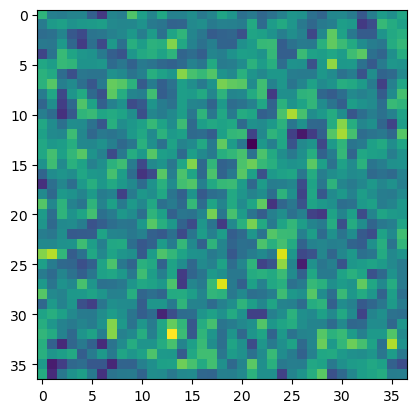

In [ ]:
plt.imshow(grads[0][0].mean((0)).detach().numpy())

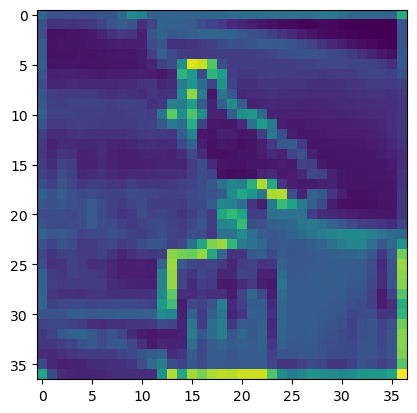

In [ ]:
plt.imshow(conv_output_0[0].mean((0)).detach().numpy())

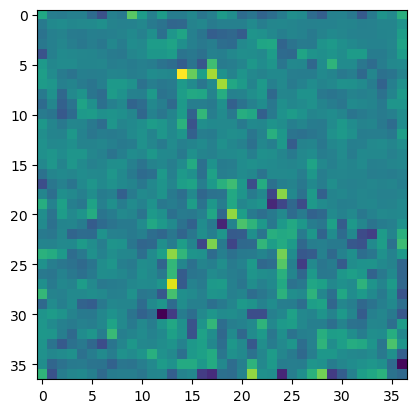

In [ ]:
plt.imshow(grads[0][0].mean((0)).detach().numpy()*conv_output_0[0].mean((0)).detach().numpy())

In [ ]:
grads

torch.Size([2, 1])

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/captum/attr/_utils/visualization.py:52: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


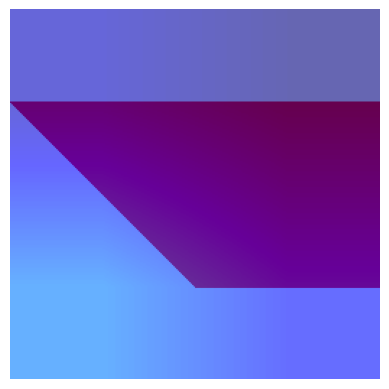

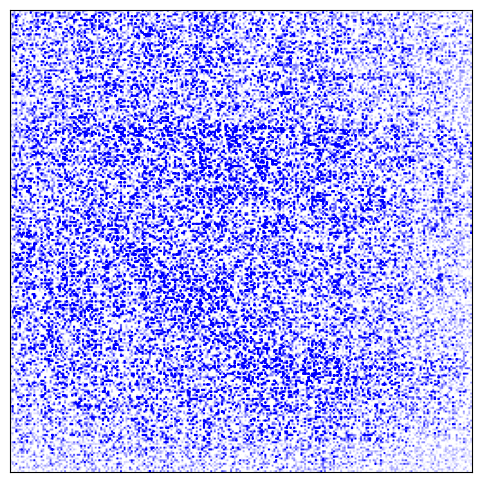

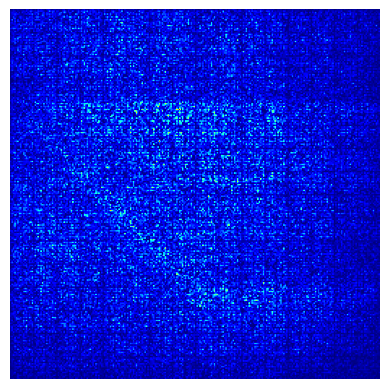

In [ ]:
for method, method_name in zip(
    [plot_gradcam,plot_integrated_gradients,plot_saliency],
    ['gradcam','integrated_gradients','saliency']
):
    plt.axis('off')
    ret = method(joint_model,run_joint_model,0,val_images,0,val_pkl)

    if method_name == 'integrated_gradients':
        ret[0].savefig('{}/{}.png'.format(results_folder,method_name),bbox_inches='tight')
    else:
        plt.savefig('{}/{}.png'.format(results_folder,method_name),bbox_inches='tight')

In [ ]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'concept_accuracy': accuracy_by_concept_train.tolist(), 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'grid_dif': float(max_dif), 
    'num_objects': num_objects, 
    'noisy': noisy,
    'weight_decay': weight_decay,
    'encoder_model': encoder_model, 
    'optimizer': optimizer, 
    'seed': seed,
}

In [ ]:
json.dump(final_data,open("{}/results.json".format(results_folder),"w"))